In [1]:
%load_ext autoreload
%autoreload 2

import pyscisci.all as pyscisci

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
try:
    import seaborn as sns
    sns.set_style('white')
except:
    pass

%matplotlib inline

In [2]:
# set this path to where the APS database will be stored
path2aps = '/home/ajgates/APS'
path2aps = '/Volumes/GatesExpansionDrive/DataSets/APS/APS2019'

In [3]:
myaps = pyscisci.APS(path2aps, keep_in_memory=False) 

# set keep_in_memory=False if you want to load the database each time its needed - good for when you 
# cant keep more than one DataFrame in memory at a time

# otherwise keep_in_memory=True will keep each DataFrame in memory after its loaded

In [4]:
pub2ref_df = myaps.pub2ref_df
pubdf = myaps.pub_df[['PublicationId', 'Date']]
pubdf['Date'] = pd.to_datetime(pubdf['Date'], infer_datetime_format=True)

In [5]:
print(pub2ref_df.shape)

pub2ref_df = pub2ref_df.merge(pubdf[['PublicationId', 'Date']], 
                                            how='left', left_on='CitingPublicationId', right_on='PublicationId')
del pub2ref_df['PublicationId']
pub2ref_df = pub2ref_df.rename(columns={'Date':'CitingDate'})

pub2ref_df = pub2ref_df.merge(pubdf[['PublicationId', 'Date']], 
                                            how='left', left_on='CitedPublicationId', right_on='PublicationId')
del pub2ref_df['PublicationId']
pub2ref_df = pub2ref_df.rename(columns={'Date':'CitedDate'})

pub2ref_df.dropna(inplace=True)

print(pub2ref_df.shape)

(8324631, 2)
(8267865, 4)


In [6]:
pub2ref_df.groupby('CitedPublicationId')['CitingPublicationId'].nunique().sort_values()

CitedPublicationId
10.1103/PhysRev.1.1                1
10.1103/PhysRevA.39.2411           1
10.1103/PhysRevD.55.6403           1
10.1103/PhysRevD.55.6584           1
10.1103/PhysRevD.55.6603           1
                               ...  
10.1103/PhysRevB.50.17953       5464
10.1103/PhysRev.136.B864        6218
10.1103/PhysRevB.54.11169       7444
10.1103/PhysRev.140.A1133       7734
10.1103/PhysRevLett.77.3865    10666
Name: CitingPublicationId, Length: 561040, dtype: int64

In [7]:
focusids = np.sort(['10.1103/PhysRev.136.B864', '10.1103/PhysRevLett.77.3865', '10.1103/PhysRev.140.A1133'])
focus_cites = pub2ref_df.loc[pyscisci.isin_sorted(pub2ref_df['CitedPublicationId'].values, focusids)]
focus_cites.sort_values(by=['CitingDate'], inplace=True)
focus_cites.shape

(24618, 4)

In [8]:
longtermimpact = pyscisci.longterm_impact(focus_cites, colgroupby = 'CitedPublicationId', coldate='CitingDate')
longtermimpact

,CitedPublicationId,lam,mu,sig
0,10.1103/PhysRev.136.B864,6.205512,9.044825,0.788842
1,10.1103/PhysRev.140.A1133,6.678506,8.936498,0.977601
2,10.1103/PhysRevLett.77.3865,8.120082,8.191955,1.419675


<ipython-input-15-afaa4813ac21>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_cites.sort_values(by=['CitingDate'], inplace=True)


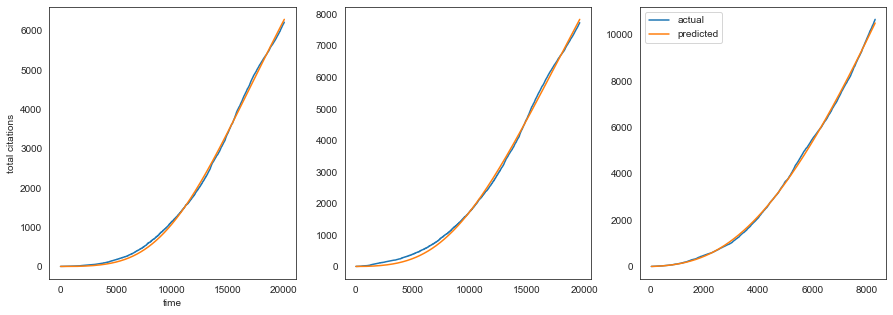

In [15]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

focus_cites.sort_values(by=['CitingDate'], inplace=True)

for iax in range(len(focusids)):
    focus_df = focus_cites[focus_cites['CitedPublicationId']==focusids[iax]]
    recenter_time = (focus_df['CitingDate'] - focus_df['CitingDate'].min() ) / np.timedelta64(1,'D')
    recenter_time = recenter_time[recenter_time>0]
    
    lam, mu, sig = longtermimpact[longtermimpact['CitedPublicationId'] == focusids[iax]][['lam', 'mu', 'sig']].values[0]
    ax[iax].plot(recenter_time, np.arange(1,len(recenter_time) + 1), label='actual') 
    
    ax[iax].plot(recenter_time, [pyscisci.predicted_c(t, lam, mu, sig) 
                                 for t in recenter_time], label='predicted')
    
ax[0].set_ylabel('total citations')
ax[0].set_xlabel('time since publication')
    
plt.legend()
plt.show()